# 📓 OCSVM - 2F - Validación por Repetición

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: mayo 2025

---

## ✨ Descripción:

Este notebook implementa un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta

**A diferencia de otros notebooks, aquí el proceso se repite múltiples veces (con diferentes semillas aleatorias en los splits) para comprobar la robustez y variabilidad del modelo.** Cada iteración realiza:

1. División de datos (train/val/test)
2. Escalado
3. Búsqueda de hiperparámetros (grid search sobre `nu` y `gamma`)
4. Evaluación sobre validación y prueba
5. Registro de métricas clave (f1-score, número de outliers, matriz de confusión)

Los resultados de cada iteración se almacenan y analizan para estimar la estabilidad del modelo.

---

## 📌 Objetivos específicos:

- Evaluar la variabilidad del modelo OCSVM tras `N` repeticiones
- Analizar la dispersión del mejor f1-score entre repeticiones
- Comparar número de anomalías detectadas en cada iteración
- Obtener métricas medias y desviaciones estándar

---

## 🗂️ Entrada de datos:

- `../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt`

## 💾 Salida esperada:

- Tabla resumen de métricas por iteración
- Mejor combinación de hiperparámetros promedio
- Exportación de anomalías más recurrentes


In [461]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix


In [462]:
# Load dataset
data_path = "../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
print(df_astro.columns)

df_astro.head()

Index(['E_peak', 'beta', 'sigma', 'beta_Rel', 'class'], dtype='object')


,E_peak,beta,sigma,beta_Rel,class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [463]:
# --- Selección de características ---
features = ['E_peak', 'beta']
target = 'class'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['E_peak', 'beta']
Columna objetivo: class

 Valores faltantes por columna:
E_peak    0
beta      0
class     0
dtype: int64

 Muestra del dataset:


,E_peak,beta,class
0,-0.412502,-1.325139,0.0
1,0.708140,-0.000174,0.0
2,0.224740,-0.581202,0.0
3,0.257319,-0.561933,0.0
4,0.326110,-1.100179,0.0


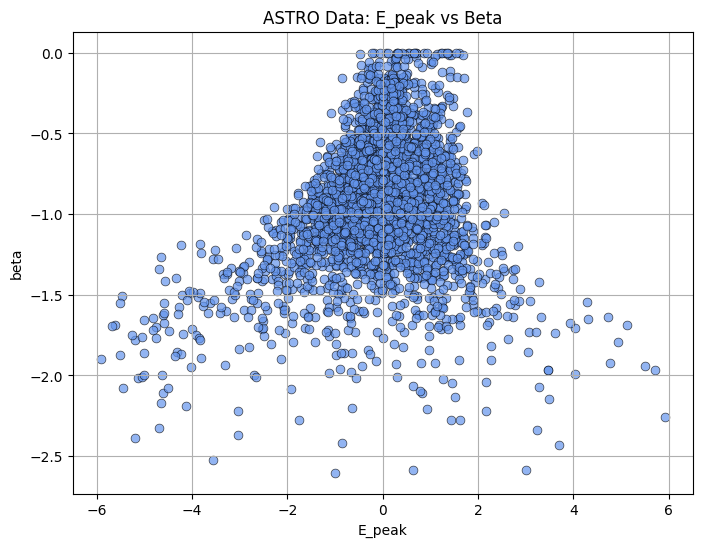

In [464]:
# Comprobamos la distribución de los datos astro antes de escalar
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_astro,
    x="E_peak",
    y="beta",
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

In [465]:
# 💥 Número de repeticiones
n_iterations = 5

# Guardar resultados de todas las iteraciones
all_iterations_results = []
best_models = []  # opcional: guardar modelo por iteración

for i in range(n_iterations):
    print(f"\n🔄 Iteración {i+1}/{n_iterations}")

    # =============== 1️⃣ Split dinámico por iteración ===============
    X = df_astro[features].values
    y = df_astro["class"].values

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42 + i
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=99 + i
    )

    # =============== 2️⃣ Escalado ===============
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # =============== 3️⃣ Grid search en esta iteración ===============
    nu_values = [0.005, 0.01, 0.02, 0.05]
    gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))

    best_score = 0.0
    best_model_iter = None
    best_params_iter = {}
    iteration_results = []

    for nu in nu_values:
        for gamma in gamma_values:
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_train_scaled)

            preds = model.predict(X_val_scaled)
            pred_labels = np.where(preds == 1, 0, 1)  # 1→normal, -1→outlier
            true_labels = y_val.astype(int)

            f1 = f1_score(true_labels, pred_labels, pos_label=0)

            iteration_results.append({'nu': nu, 'gamma': gamma, 'f1_score': f1})

            if f1 > best_score:
                best_score = f1
                best_model_iter = model
                best_params_iter = {'nu': nu, 'gamma': gamma}

    print(f"✅ Mejor iteración {i+1}: nu={best_params_iter['nu']}, gamma={best_params_iter['gamma']}, F1={best_score:.4f}")

    # Guardar resultados de esta iteración
    all_iterations_results.extend(
        [dict(iter=i+1, **res) for res in iteration_results]
    )

    best_models.append(best_model_iter)  # opcional

# 🎉 Convertimos a DataFrame global
df_all_results = pd.DataFrame(all_iterations_results)

# Mostrar el top global
display(df_all_results.sort_values(by='f1_score', ascending=False))



🔄 Iteración 1/5
✅ Mejor iteración 1: nu=0.005, gamma=0.01, F1=0.9956

🔄 Iteración 2/5
✅ Mejor iteración 2: nu=0.005, gamma=0.01, F1=0.9965

🔄 Iteración 3/5
✅ Mejor iteración 3: nu=0.005, gamma=0.1, F1=0.9982

🔄 Iteración 4/5
✅ Mejor iteración 4: nu=0.005, gamma=0.001, F1=0.9929

🔄 Iteración 5/5
✅ Mejor iteración 5: nu=0.005, gamma=0.01, F1=1.0000


,iter,nu,gamma,f1_score
115,5,0.005,0.01,1.000000
114,5,0.005,0.001,0.999116
116,5,0.005,0.1,0.998230
60,3,0.005,0.1,0.998230
122,5,0.010,0.01,0.998230
...,...,...,...,...
97,4,0.010,10.0,0.743618
62,3,0.005,10.0,0.740823
6,1,0.005,10.0,0.726659
90,4,0.005,10.0,0.709236


In [466]:
for i, model in enumerate(best_models):
    test_preds = model.predict(X_test_scaled)
    test_labels = np.where(test_preds == 1, 0, 1)
    print(f"\n📝 Iteración {i+1}")
    print(confusion_matrix(y_test, test_labels))
    print(classification_report(y_test, test_labels, target_names=['Normal', 'Anomalía']))


📝 Iteración 1
[[565   2]
 [  0   0]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       567
    Anomalía       0.00      0.00      0.00         0

    accuracy                           1.00       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      1.00      1.00       567


📝 Iteración 2
[[565   2]
 [  0   0]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       567
    Anomalía       0.00      0.00      0.00         0

    accuracy                           1.00       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      1.00      1.00       567


📝 Iteración 3
[[564   3]
 [  0   0]]
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       567
    Anomalía       0.00      0.00      0.00         0

    accuracy                           0.99       567
   macro avg  

/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [467]:
# Paso 1: identificar hiperparámetros globales
best_global = df_all_results.sort_values(by='f1_score', ascending=False).iloc[0]
print("Mejor combinación global:")
print(best_global)

# Paso 2: reentrenar con X_train + X_val
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)
X_test_scaled = scaler_final.transform(X_test)

# Paso 3: entrenar modelo final
final_model = OneClassSVM(kernel='rbf', nu=best_global['nu'], gamma=best_global['gamma'])
final_model.fit(X_final_train_scaled)

# Paso 4: evaluar en test
test_preds = final_model.predict(X_test_scaled)
test_labels = np.where(test_preds == 1, 0, 1)

print(confusion_matrix(y_test, test_labels))
print(classification_report(y_test, test_labels, target_names=['Normal', 'Anomalía']))

Mejor combinación global:
iter            5
nu          0.005
gamma        0.01
f1_score      1.0
Name: 115, dtype: object
[[564   3]
 [  0   0]]
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       567
    Anomalía       0.00      0.00      0.00         0

    accuracy                           0.99       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      0.99      1.00       567



/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

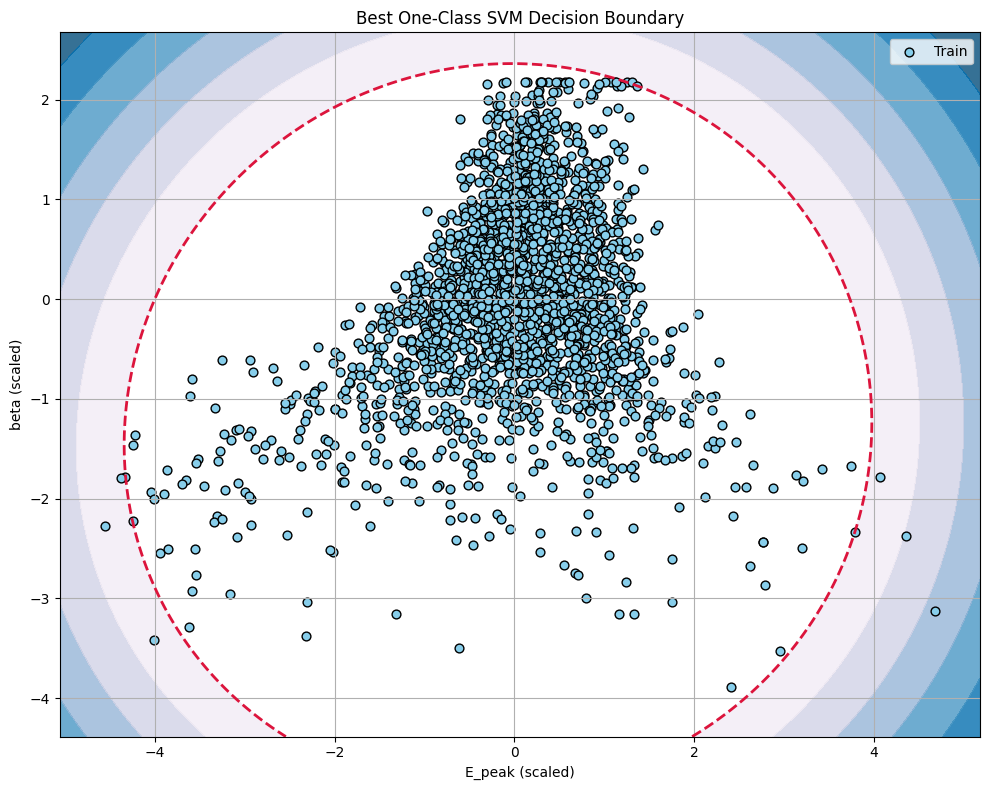

In [468]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_final_train_scaled[:, 0].min() - 0.5, X_final_train_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_final_train_scaled[:, 1].min() - 0.5, X_final_train_scaled[:, 1].max() + 0.5, 300)   # beta
)

grid = np.c_[xx.ravel(), yy.ravel()]

Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_final_train_scaled[:, 0], X_final_train_scaled[:, 1], c='skyblue', edgecolors='k', s=40, label='Train')

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Predict on UNIDs

In [469]:
unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


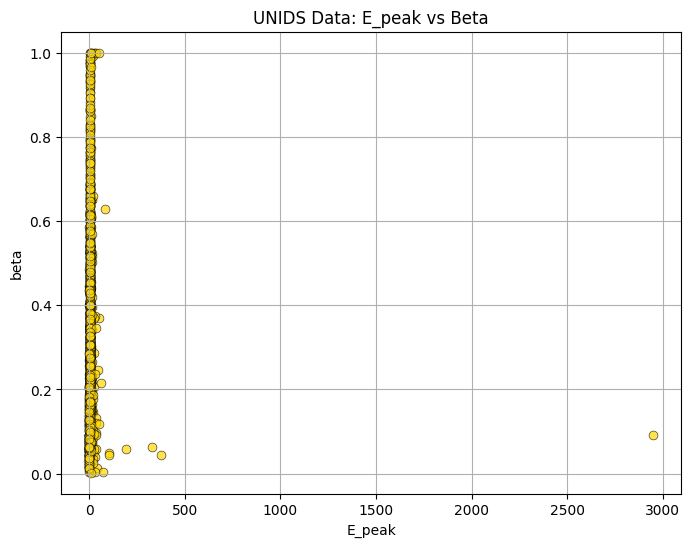

In [470]:
# Scatter de unids para comprobar que no hay problemas
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_unids,
    x="E_peak",
    y="beta",
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("UNIDS Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

In [471]:
# convertimos a logaritmo
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

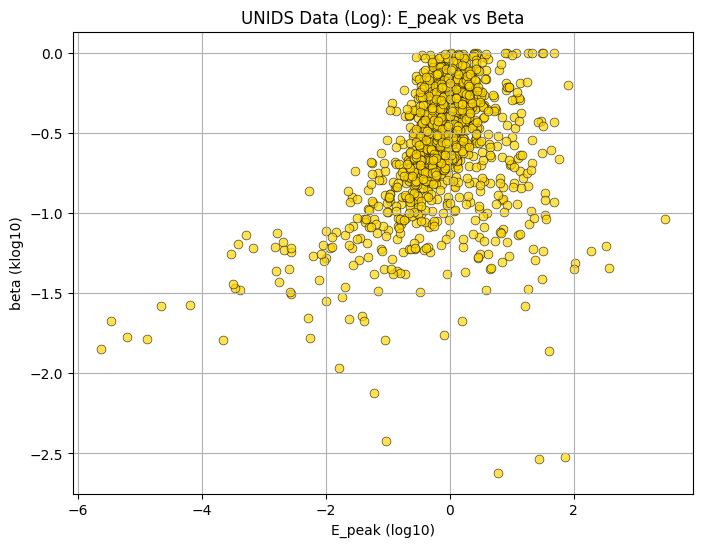

In [472]:
# scatter de unids después de log
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_unids_log,
    x="E_peak",
    y="beta",
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("UNIDS Data (Log): E_peak vs Beta")
plt.xlabel("E_peak (log10)")
plt.ylabel("beta (klog10)")
plt.grid(True)
plt.show()

In [473]:
# Extraer y escalar
X_unids_log = df_unids_log[["E_peak", "beta"]].values
X_unids_scaled = scaler.transform(X_unids_log)

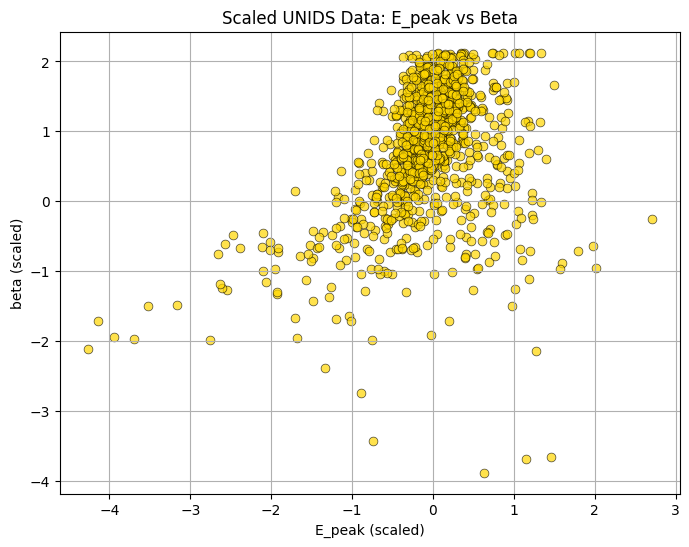

In [474]:
# Scatter de unids después de escalar
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled UNIDS Data: E_peak vs Beta")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.grid(True)
plt.show()

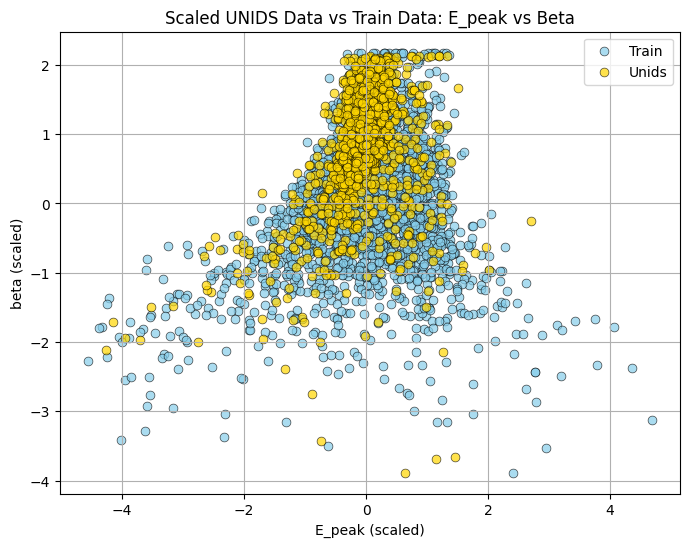

In [475]:
# Scatter de unids escalados vs datos de entrenamiento escalados
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Train'
)
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Unids'
)
plt.title("Scaled UNIDS Data vs Train Data: E_peak vs Beta")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.legend()
plt.grid(True)
plt.show()

In [476]:
# Predecir con el modelo final
unids_preds = final_model.predict(X_unids_scaled)
unids_labels = np.where(unids_preds == 1, 0, 1)  # 1→normal, -1→outlier

# Añadir etiquetas al DataFrame
df_unids_log['pred_labels'] = unids_labels

# Filtrar los datos no clasificados
df_unids_log['pred_labels'] = df_unids_log['pred_labels'].astype(int)
df_unids_log['pred_labels'] = df_unids_log['pred_labels'].replace({0: 'Normal', 1: 'Anomalía'})


In [477]:
df_unids_log.head()

,E_peak,beta,sigma_det,beta_Rel,number,pred_labels
0,0.400175,-1.047208,0.869208,0.212452,0,Normal
1,0.169733,-0.380594,0.733598,-0.113037,1,Normal
2,0.203142,-0.168578,1.033058,-0.430366,2,Normal
3,-0.031074,-0.557363,0.881133,-0.201588,3,Normal
4,-0.351835,-0.493901,0.630916,-0.246028,4,Normal


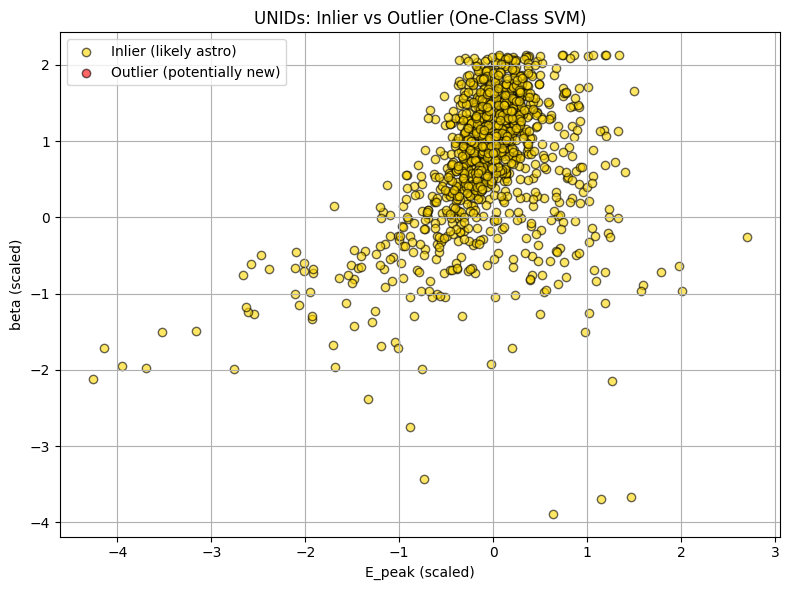

In [478]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(8, 6))

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")

plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

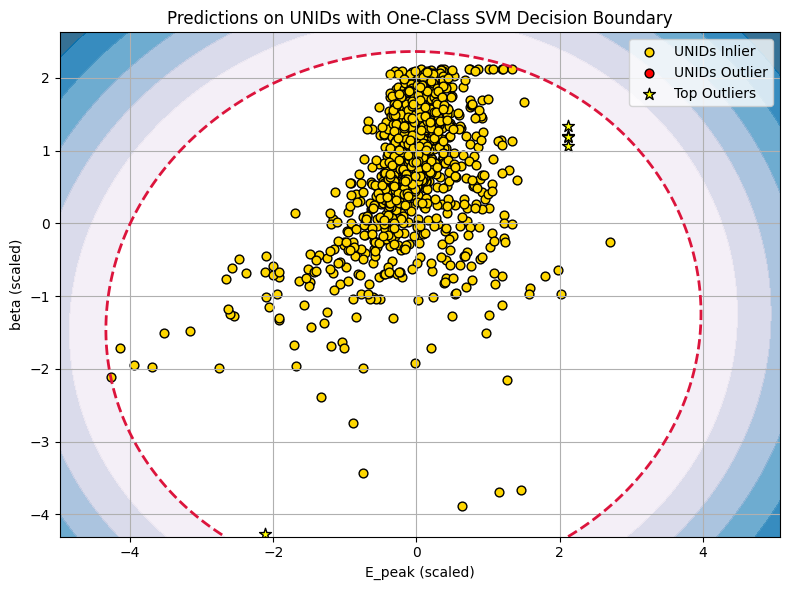

In [479]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300)   # beta
)

grid = np.c_[xx.ravel(), yy.ravel()]  # correcto orden

Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

preds_unids = final_model.predict(X_unids_scaled)
inliers = X_unids_scaled[preds_unids == 1]
outliers = X_unids_scaled[preds_unids == -1]

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', s=40, label='UNIDs Inlier')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', s=40, label='UNIDs Outlier')

# Highlight most anomalous UNIDs using their lowest decision score:
decision_scores = final_model.decision_function(X_unids_scaled)
# Optional: mark top 5 most anomalous
top_anomalies = X_unids_scaled[np.argsort(decision_scores)[:5]]
plt.scatter(top_anomalies[:, 1], top_anomalies[:, 0], c='yellow', edgecolors='black', s=80, label='Top Outliers', marker='*')


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Predictions on UNIDs with One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Anomaly Scoring - UNIDs

In [480]:
decision_scores = final_model.decision_function(X_unids_scaled)  # Higher = more normal, lower = more anomalous

unids_preds = final_model.predict(X_unids_scaled)  # 1 = inlier, -1 = outlier

df_unids_log["svm_score"] = decision_scores
df_unids_log["prediction"] = unids_preds

anom_scores = -decision_scores  # Invert: higher = more anomalous
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

df_unids_log["Anomaly_Score"] = anom_scores
df_unids_log["Anomaly_Rank(%)"] = anom_percent

top_anomalies = df_unids_log[df_unids_log["prediction"] == -1].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)
most_anomalous_idx = top_anomalies.index

top_anomalies.to_csv("../../data/processed/unids_most_anomalous.txt", sep="\t", index=False)

print("Top Most Anomalous UNID Sources (4F One-Class SVM):")
display(top_anomalies[['number', 'Anomaly_Score', 'Anomaly_Rank(%)']])

Top Most Anomalous UNID Sources (4F One-Class SVM):


,number,Anomaly_Score,Anomaly_Rank(%)


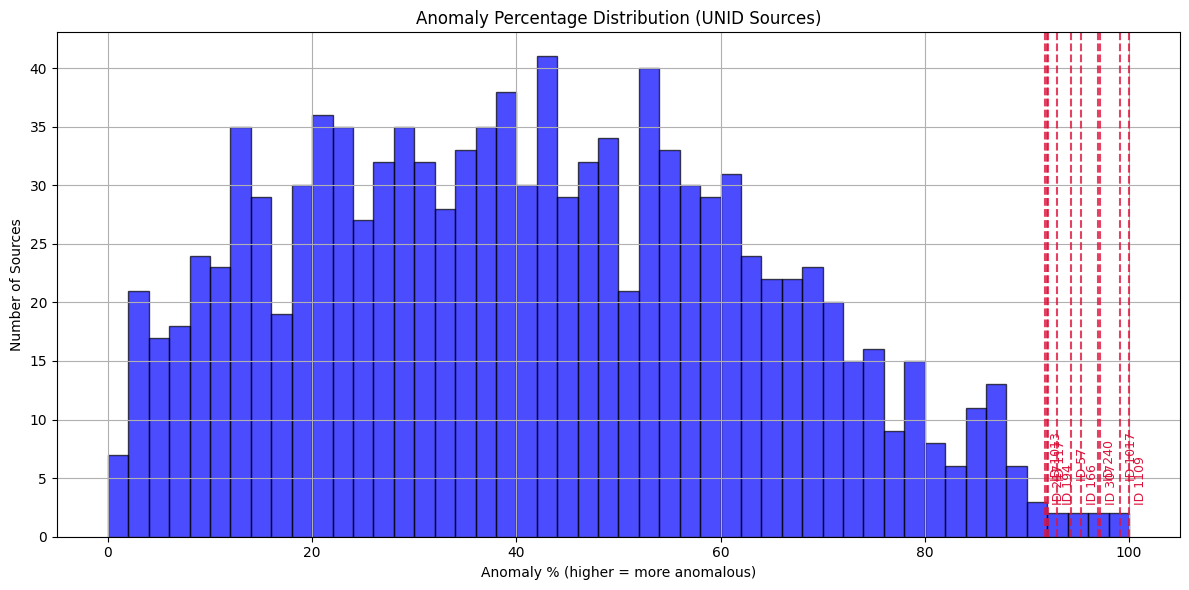

In [481]:
# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids_log.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


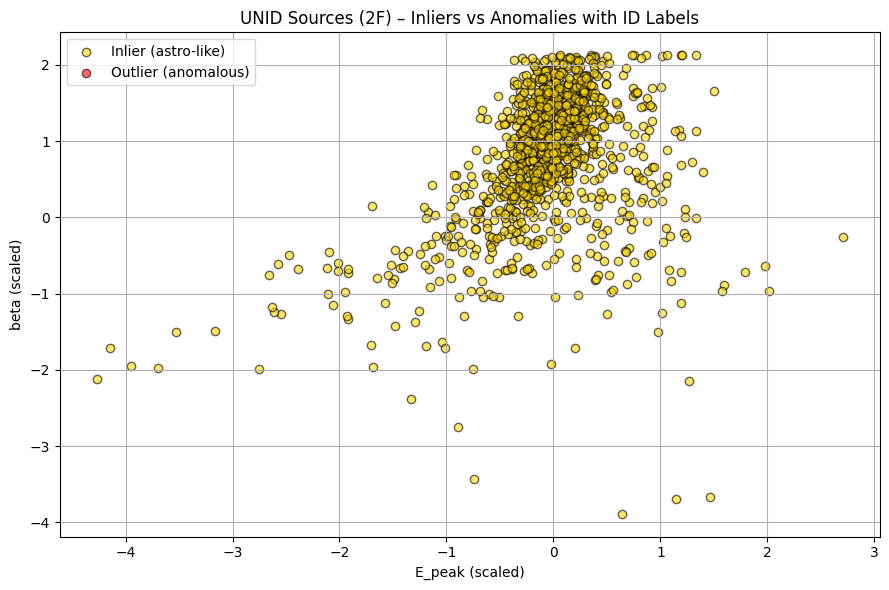

In [482]:
plt.figure(figsize=(9, 6))

# Inliers and outliers from scaled data
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

# Plot inliers (gold)
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (astro-like)', alpha=0.6)

# Plot outliers (red)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (anomalous)', alpha=0.6)

# Annotate top 10 anomalies by ID
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 0]  # E_peak (scaled)
    y = X_unids_scaled[idx, 1]  # beta (scaled)
    label = int(df_unids_log.loc[idx, 'number'])
    plt.text(x + 0.1, y, str(label), color='black', fontsize=9)

# Axis labels and styling
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNID Sources (2F) – Inliers vs Anomalies with ID Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../../outputs/figures/scaled/2F_UNIDs_OneClassSVM_2D_scaled.png", dpi=300, bbox_inches='tight')

plt.show()


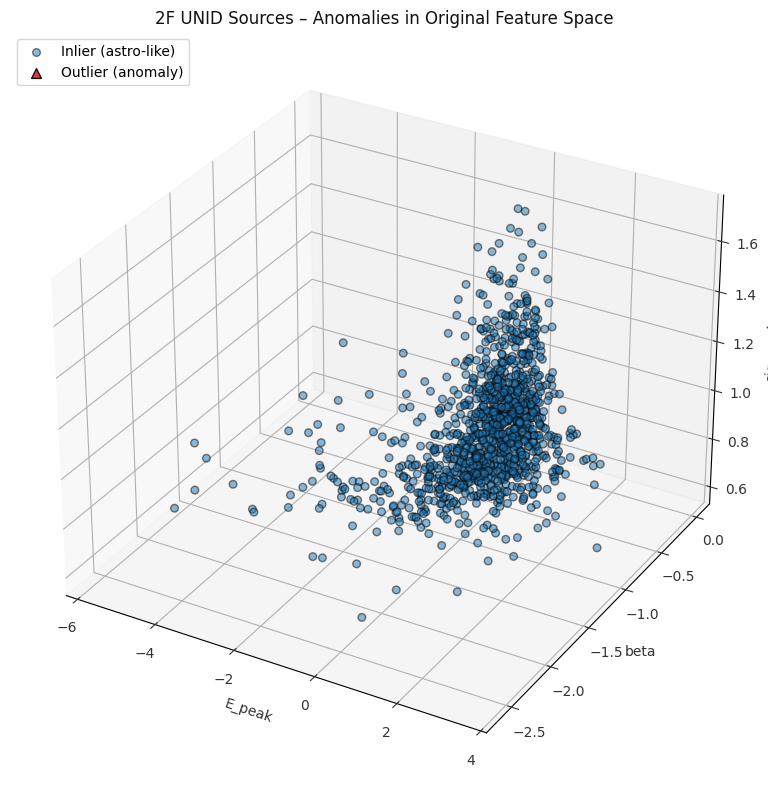

In [483]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original/log-transformed values for 3 relevant features
x_vals = df_unids_log['E_peak'].values
y_vals = df_unids_log['beta'].values
z_vals = df_unids_log['sigma_det'].values  # or 'beta_Rel' for 3F.2

# Use model predictions for coloring
inlier_idx = df_unids_log['prediction'] == 1
outlier_idx = df_unids_log['prediction'] == -1

# Inliers
ax.scatter(
    x_vals[inlier_idx], y_vals[inlier_idx], z_vals[inlier_idx],
    c='#1f77b4', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.5
)

# Outliers
ax.scatter(
    x_vals[outlier_idx], y_vals[outlier_idx], z_vals[outlier_idx],
    c='#d62728', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
top_anomalies = df_unids_log[df_unids_log['prediction'] == -1].sort_values('Anomaly_Rank(%)', ascending=False).head(10)
for idx in top_anomalies.index:
    ax.scatter(
        x_vals[idx], y_vals[idx], z_vals[idx],
        facecolors='none', edgecolors='black', linewidths=2, s=100
    )
    ax.text(
        x_vals[idx], y_vals[idx], z_vals[idx] + 0.05,
        str(int(df_unids_log.loc[idx, 'number'])),
        color='black', fontsize=9
    )

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma_det')  # or 'beta_Rel'
ax.set_title("2F UNID Sources – Anomalies in Original Feature Space")
ax.legend(loc='upper left')

ax.tick_params(colors='#333333')
ax.xaxis.label.set_color('#333333')
ax.yaxis.label.set_color('#333333')
ax.zaxis.label.set_color('#333333')
ax.title.set_color('#111111')
ax.grid(color='#aaaaaa', linestyle='--', alpha=0.3)

plt.savefig("../../outputs/figures/2F_UNIDs_OneClassSVM_og.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Comparar con UNIDs ANN

In [484]:
ann_unids_path = "../ANN_4F/unids_DM_std_proba_check_repeated_kfold_rskf_4F_21.txt"

raw_ann_unids_data = np.genfromtxt(ann_unids_path, dtype='str')
ann_unids_data = np.asarray(raw_ann_unids_data[1:], dtype=float)  # Salta cabecera
n_samples = ann_unids_data.shape[1] - 1

columns = ['number'] + [f'prob_{i}' for i in range(n_samples)]
df_unids_ann = pd.DataFrame(ann_unids_data, columns=columns)

df_unids_ann.head()

,number,prob_0
0,0.0,6.583166e-10
1,1.0,3.137251e-01
2,2.0,4.082428e-01
3,3.0,9.984947e-02
4,4.0,2.016772e-01


In [485]:
# Media por fuente y entre folds
df_mean_unids_ann = df_unids_ann.groupby('number').mean().reset_index()
df_mean_unids_ann['prob_ann'] = df_mean_unids_ann[[f'prob_{i}' for i in range(n_samples)]].mean(axis=1)

df_mean_unids_ann.head()

,number,prob_0,prob_ann
0,0.0,1.860129e-10,1.860129e-10
1,1.0,3.032059e-01,3.032059e-01
2,2.0,5.515580e-01,5.515580e-01
3,3.0,1.494101e-01,1.494101e-01
4,4.0,2.391825e-01,2.391825e-01


In [486]:
# Get the 10 sources with the highest mean ANN DM probability
top_ann_unids = df_mean_unids_ann.sort_values('prob_ann', ascending=False).head(10)

# Display results
print("🔝 Top 10 UNIDs with highest ANN-based DM probability:")
display(top_ann_unids[['number', 'prob_ann']])


🔝 Top 10 UNIDs with highest ANN-based DM probability:


,number,prob_ann
33,33.0,1.000000
843,843.0,0.999999
709,709.0,0.999995
923,923.0,0.999552
1054,1054.0,0.999522
1107,1107.0,0.999414
717,717.0,0.998058
477,477.0,0.997570
1103,1103.0,0.994799
542,542.0,0.994276


In [487]:
df_compare = pd.merge(
    df_mean_unids_ann[['number', 'prob_ann']],
    df_unids_log[['number', 'Anomaly_Rank(%)']],
    on='number'
)

# Sort by ANN prediction and OCSVM anomaly rank
df_compare.sort_values(['prob_ann', 'Anomaly_Rank(%)'], ascending=[False, False]).head(10)


,number,prob_ann,Anomaly_Rank(%)
33,33.0,1.000000,53.339464
843,843.0,0.999999,59.556230
709,709.0,0.999995,64.155182
923,923.0,0.999552,62.558157
1054,1054.0,0.999522,56.918074
1107,1107.0,0.999414,32.139877
717,717.0,0.998058,34.424905
477,477.0,0.997570,43.641975
1103,1103.0,0.994799,26.017357
542,542.0,0.994276,60.552245


In [488]:
df_compare[
    (df_compare['prob_ann'] > 0.9) & 
    (df_compare['Anomaly_Rank(%)'] > 80.0)
]


,number,prob_ann,Anomaly_Rank(%)
287,287.0,0.956315,81.178108
